# Obama's Briefing Topic Analysis


In [58]:
import string;
import nltk
import json
import ast
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import collections


from collections import defaultdict
from boltons.jsonutils import JSONLIterator
from boltons.dictutils import OMD
from lxml.html import soupparser
from lxml.cssselect import CSSSelector

## Data

Obama’s briefings were found in the whitehouse webpage. We use the data file at github, which is the download from whitehouse homepage, “ https://www.whitehouse.gov/briefings-statements/ ”. The data file can be found at “ https://github.com/mahmoud/briefings “ 
Briefings.jsonl : 1778 Obama’s briefings from 2009 to 2016. 


In [49]:
BRIEFINGS_FILE = '/Users/kim.jiy/documents/springboard/topic/data/briefings/briefings.jsonl'


In [50]:
import string;
import nltk
import json
import ast
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

stemmer = SnowballStemmer("english")


## Data Cleaning and Preparation

Punctuation : punctuation such as “a”, “!” , “?”, ets were removed at each contents of briefings using “string.punctuation” provided from Python

Unicode implementation: To have words encoded using Unicode encoding, I encoded text type to  utf-8 and remove any numbers and also change 
every words to lower cases.  

tokenization : Tokenized every words in contents


In [51]:
# Data Cleaning. From the briefing file , meaningless words are removed and each words are tokenized. 

def makeInputDate(briefing_text):
    
    # remove punctuation
    exclude = set(string.punctuation)
    s = briefing_text
    
    # store words which are not puncuation to "s"
    s = ''.join(ch for ch in s if ch not in exclude)
    
    
    # encode text type to  utf-8 and remove any numbers. also change every words to lower case. 
    s1 = str(s.encode('utf-8')).translate(None, '0123456789').lower()
    
    # store tokenize words to "tokens"
    tokens = nltk.word_tokenize(s1)

    # use "stopwords.words" from nltk package. "stopwords.words" are meaninless words. 
    stop_words = set(stopwords.words('english'))
    
    # "additional_stop_words" is the set of meaningless words which are added from the result of the model. 
    #  After results come out from the mathematical model, "additional_stop_words" is added with the meaningless words from the result
    additional_stop_words = ['presid','mr','say','think','go','well','get','q','said','veri'
                 , 'jame', 'bradi','press','brief','room','pm','est','go','got'
                 , 'ive','g','weve', 'one', 'dont', 'doe', 'de', 'hes','would'
                 ,'ani','also', 'gibb','earnest','carney']

    stop_words.update(additional_stop_words)

    output = []
    
    num_meaning = len(tokens)
    num_meaningless= 0
    # each tokenized words are meaningless words, which are included in "stop_words" or "additional_stop_words", i is not 0. 
    for token in tokens:
        

        # removing morphological affixes
        try:
            stemms = stemmer.stem(token);

        except UnicodeDecodeError:
            stemms = "UnicodeDecodeError";

        i = 0;
        
        
        
        # check if word is in the set of meaningless words, "stop_words". 

        try:
            if stemms in stop_words:
                i += 1
                num_meaningless +=1;
            elif stemms in additional_stop_words:
                i += 1
                num_meaningless +=1;

        except UnicodeDecodeError:
                i += 1
                num_meaningless +=1;

        try:
            if i == 0 and stemms != "UnicodeDecodeError":
                output.append(str(stemms.encode('utf8')))
        except UnicodeDecodeError:
            i += 1




    return output, num_meaningless , num_meaning;

Gather list of meaningful words to "description"

In [52]:
jsonl_iter = JSONLIterator(open(BRIEFINGS_FILE))


res = defaultdict(list)

# To check how many briefings in total
nums = 0;
descriptions = []

# To count the number of meaningful words 
num_mean = []

# To count the number of meaningless words
num_meanless = []


for obj in jsonl_iter:
    title = obj['title']
    briefing_html = obj['content']
    
    # parse html 
    content_tree = soupparser.fromstring(briefing_html)
    
    pane_tree = content_tree.cssselect('.pane-node-field-forall-body')
    briefing_text = pane_tree[0].text_content()
    
    # store meaningful words from briefings to "descriptions"
    outs = makeInputDate(briefing_text)
    
    descriptions.append(outs[0])
    num_mean.append(outs[2])
    num_meanless.append(outs[1])
    
    nums += 1;
    


There are 1778 breifings in total

In [53]:
# Let's check how many brefings in total.

print(nums)

1778


## Data Storytelling

Let's check how many words in each briefings. 

In [22]:
# the number of words before removing punctuation 

print( np.mean(num_mean), np.amin(num_mean), np.amax(num_mean))

(7016.9325084364455, 101, 24271)


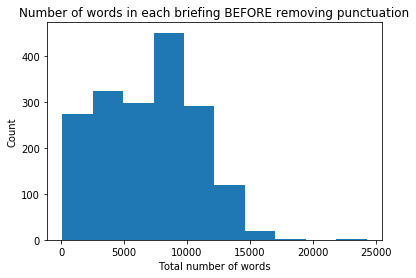

In [61]:

plt.hist(num_mean)
plt.title("Number of words in each briefing BEFORE removing punctuation")
plt.xlabel("Total number of words")
plt.ylabel("Count")
plt.show()

In [32]:
# # the number of words before removing punctuation after removing punctuation

words = np.subtract(num_mean,num_meanless)
print( np.mean(words), np.amin(words), np.amax(words))

(3207.115298087739, 62, 10929)


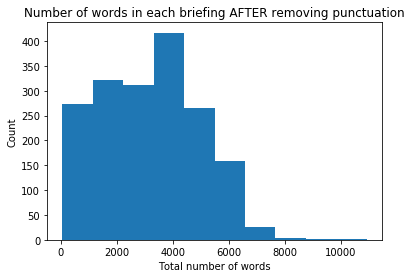

In [62]:

plt.hist(words)
plt.title("Number of words in each briefing AFTER removing punctuation")
plt.xlabel("Total number of words")
plt.ylabel("Count")
plt.show()

In [54]:
uniq_nums = []
for desc in descriptions:
    for word in desc:
        uniq_nums.append(word)

ctr = collections.Counter(uniq_nums)

print("Frequency of the elements in the List : ",ctr)

4872886

## Machine Learning


First, I constructed words in "descriptions" vs ID mapping table to efficeintly apply values to models. Then,dictionary was converted into a bag-of-words. The result, corpus , is a list of vectors equal to the number of documents. In each document vector is a series of tuples
  
To run any mathematical model on text corpus, it is converted into a matrix representation.

In [72]:
from gensim import corpora, models, similarities
import logging, gensim, bz2


# Construct words in "descriptions" vs ID mapping table to map same tokens to the same IDs 
dictionary = corpora.Dictionary(descriptions)
type(dictionary.token2id)

## converts dictionary into a bag-of-words. The result, corpus , is a list of vectors equal to the number of documents. In each document vector is a series of tuples
 
raw_corpus2 = [dictionary.doc2bow(t) for t in descriptions]

### LDA

This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. 

In [82]:
lda = gensim.models.ldamodel.LdaModel(corpus=raw_corpus2, id2word=dictionary, num_topics=10, update_every=1, chunksize=50, passes=1)
print_lda = lda.print_topics(10)

for i in print_lda:
    print i

#lsi = gensim.models.lsimodel.LsiModel(corpus=raw_corpus2, id2word=dictionary, num_topics=10)
#print_lsi = lsi.print_topics(10)

ldatopics = lda.show_topics(formatted=False)

(0, u'0.013*"know" + 0.012*"talk" + 0.010*"look" + 0.009*"peopl" + 0.009*"senat" + 0.008*"hous" + 0.007*"robert" + 0.007*"like" + 0.006*"time" + 0.006*"im"')
(1, u'0.010*"know" + 0.007*"question" + 0.007*"obvious" + 0.007*"secretari" + 0.007*"inform" + 0.007*"administr" + 0.006*"believ" + 0.006*"white" + 0.006*"im" + 0.006*"peopl"')
(2, u'0.017*"health" + 0.016*"care" + 0.009*"im" + 0.008*"administr" + 0.008*"peopl" + 0.006*"way" + 0.006*"iran" + 0.006*"talk" + 0.006*"know" + 0.005*"want"')
(3, u'0.014*"que" + 0.007*"state" + 0.006*"unit" + 0.006*"intern" + 0.006*"un" + 0.006*"regim" + 0.005*"iran" + 0.005*"peopl" + 0.005*"administr" + 0.004*"know"')
(4, u'0.015*"afghanistan" + 0.010*"secur" + 0.008*"troop" + 0.008*"forc" + 0.008*"us" + 0.007*"iraq" + 0.006*"afghan" + 0.006*"militari" + 0.006*"pakistan" + 0.006*"govern"')
(5, u'0.011*"meet" + 0.009*"issu" + 0.008*"discuss" + 0.008*"secur" + 0.007*"countri" + 0.007*"state" + 0.007*"us" + 0.006*"nuclear" + 0.006*"talk" + 0.006*"unit"')
(

### Parameter tuning for LDA

LDA require a num_topics parameter (set to 200 by default) to determine the number of latent dimensions after the SVD. So several numbers of topics were tested on the model to pick the best one. Coherence socre was used to measure the model. Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models. 

In [83]:
cm = CoherenceModel(model=lda, texts=descriptions, dictionary=dictionary, coherence='c_v')

In [84]:
cm.get_coherence()

0.30416152018490256

In [88]:
# number of topics were tried to find the optimal number of topics

num_topic = [12, 15, 17, 19 , 21, 23, 35]
cohere_list = []
for i in num_topic:
    cur_lda = gensim.models.ldamodel.LdaModel(corpus=raw_corpus2, id2word=dictionary, num_topics=i, update_every=1, chunksize=50, passes=1)
    cm = CoherenceModel(model=cur_lda, texts=descriptions, dictionary=dictionary, coherence='c_v')
    cohere_list.append(cm.get_coherence())

cohere_list

[0.33484294159560335,
 0.35966608955121787,
 0.3274961726918447,
 0.3315125671026826,
 0.38043867029440886,
 0.3868766547947702,
 0.37080424123187417]

The best model was with the number of topics of 23 from the graph below. 

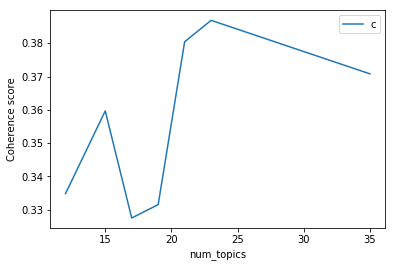

In [89]:
plt.plot(num_topic, cohere_list)
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')
plt.show()

Let's visulize the result

In [90]:

lda_opt = gensim.models.ldamodel.LdaModel(corpus=raw_corpus2, id2word=dictionary, num_topics=23, update_every=1, chunksize=50, passes=1)
followers_data =  pyLDAvis.gensim.prepare(lda_opt, raw_corpus2, dictionary)
pyLDAvis.display(followers_data)

  

### LSI 

This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order.

In [78]:

from gensim.models.coherencemodel import CoherenceModel


lsi = gensim.models.lsimodel.LsiModel(corpus=raw_corpus2, id2word=dictionary, num_topics=10)
coherencemodel = CoherenceModel(model=lsi, texts=descriptions, dictionary=dictionary, coherence='c_v')
coherencemodel.get_coherence()

0.3240725411820363

In [79]:
# take a look at topics when it is 5

lsi.show_topics(num_topics=5)

[(0,
  u'0.179*"state" + 0.169*"make" + 0.161*"peopl" + 0.137*"know" + 0.132*"unit" + 0.130*"talk" + 0.126*"work" + 0.123*"take" + 0.122*"us" + 0.121*"becaus"'),
 (1,
  u'-0.309*"unit" + -0.296*"state" + -0.174*"secur" + 0.172*"tax" + -0.156*"countri" + 0.151*"job" + 0.136*"look" + -0.131*"militari" + 0.124*"cut" + -0.122*"isil"'),
 (2,
  u'-0.331*"republican" + -0.211*"hous" + -0.192*"congress" + -0.174*"senat" + 0.172*"us" + 0.171*"meet" + 0.170*"issu" + 0.150*"discuss" + -0.146*"american" + -0.134*"democrat"'),
 (3,
  u'0.243*"tax" + -0.186*"health" + 0.183*"congress" + 0.175*"cut" + -0.163*"peopl" + -0.161*"know" + -0.160*"care" + -0.135*"look" + 0.131*"economi" + 0.130*"deficit"'),
 (4,
  u'0.204*"iran" + 0.191*"agreement" + -0.189*"militari" + -0.184*"forc" + 0.181*"nuclear" + 0.167*"republican" + -0.165*"american" + 0.160*"senat" + 0.156*"meet" + -0.145*"iraq"')]

In [80]:
sitopics = lsi.show_topics(formatted=False)

In [81]:
import pyLDAvis.gensim



### Parameter tuning for LSI

The number of topic needs to be decided like LDA. 

In [ ]:
cm = CoherenceModel(model=lsi, texts=descriptions, dictionary=dictionary, coherence='c_v')

# number of topics were tried to find the optimal number of topics

num_topic = [12, 15, 17, 19 , 21, 23, 35]
cohere_list_lsi = []
for i in num_topic:
    cur_lsi = gensim.models.lsimodel.LsiModel(corpus=raw_corpus2, id2word=dictionary, num_topics=i)
    cm = CoherenceModel(model=cur_lsi, texts=descriptions, dictionary=dictionary, coherence='c_v')
    cohere_list_lsi.append(cm.get_coherence())

cohere_list_lsi

In [ ]:
plt.plot(num_topic, cohere_list)
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')
plt.show()

###  Visualization

In [ ]:
followers_data =  pyLDAvis.gensim.prepare(lda, raw_corpus2, dictionary)
pyLDAvis.display(followers_data)

